In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState
from pflow.optimal_transport.transportation_plan import Reweighting

In [2]:
import torch

In [3]:
import numpy as np

In [4]:
class BrownianProposalMethod:
    def __init__(self, lower_triang_chol):
        locs = torch.zeros(lower_triang_chol.shape[0], requires_grad=False)
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=lower_triang_chol)
        
    def apply(self, state, _observation):
        x = state.x
        loc = x[:, 0]
        vel = x[:, 1]
        sample = self._dist.rsample((x.shape[0],))
        vel_proposed = vel + sample[:, 1]
        loc_proposed = loc + vel_proposed + sample[:, 0]
        x_proposed = torch.stack([loc_proposed, vel_proposed], 1)
        return FilterState(x=x_proposed, w=state.w, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod:
    def __init__(self, sigma):
        self._dist = torch.distributions.Normal(loc=0., scale=sigma)
        
    def apply(self, state, observation):
        distance = state.x[:, 0] - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        return log_probs.exp()
        
class SystematicResampling:
    def apply(self, x, w):
        u = torch.rand(())
        n = x.shape[0]
        probs = (torch.arange(n, dtype=w.dtype) + u) / n
        cumsum = w.cumsum(0)
        indices = np.searchsorted(cumsum.detach(), probs)
        return x[indices, :], torch.full_like(w, 1/n)


In [5]:
_ = torch.random.manual_seed(0)

In [6]:
import math
import random
random.seed(42)

In [7]:
def generate_sine(dt, seed=42):
    random.seed(seed)
    t = 0
    while True:
        yield math.sin(t) + (random.random()-0.5)/5.
        t += dt

In [8]:
dt = 0.1
K = 100

sine_gen = generate_sine(dt)

In [9]:
def run_pf(lower, log_sigma):
    n = 50
    states = []
    observations = []
    initial_x = torch.zeros((n, 2), requires_grad=True)
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    lower = torch.zeros((2, 2), requires_grad=False)
    tril_indices = torch.tril_indices(row=2, col=2, offset=0)
    lower[tril_indices[0], tril_indices[1]] = flat

    sigma = log_sigma.exp()
    state = FilterState(x=initial_x, w=initial_w, n=n, loglik=initial_log_lik)
    
    boot = BootstrapFilter(proposal_method=BrownianProposalMethod(lower),
                           likelihood_method=LikelihoodMethod(sigma), 
                           #reweighting_method=SystematicResampling(),
                           reweighting_method=Reweighting(epsilon=0.1, scaling=0.9, reach = 0.1),  
                           min_neff=0.5)
    
    for _ in range(K):
        obs = Observation(torch.tensor(next(sine_gen), requires_grad=False))
        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        state = boot.predict(state, None)
    return -state.loglik, states, observations

In [10]:
log_sigma = torch.tensor(-1., requires_grad=True)
flat = torch.tensor([0.1,0., 0.1], requires_grad=True)


In [11]:
# with torch.autograd.detect_anomaly():
res = run_pf(flat, log_sigma)

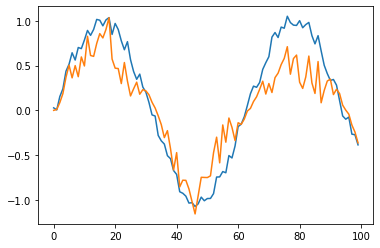

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.plot([(l.x[:, 0] * l.w).detach().numpy().mean() for l in res[1]])
plt.plot([l.y.detach().numpy().mean() for l in res[2]])
plt.plot([(l.x[:, 0] * l.w).detach().numpy().sum() for l in res[1]])
# plt.plot([(l.x[:, 1] * l.w / dt).detach().numpy().sum() for l in res[1]])